# Downloading the dataset

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

In [ ]:
with zipfile.ZipFile('chest-xray-pneumonia/chest-xray-pneumonia.zip', 'r') as zip:
    zip.extractall('chest-xray-pneumonia')

# Importing modules

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import albumentations as A
import cv2
import json

from skimage.io import imread
from skimage.transform import resize
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Preparing the dataset

In [3]:
count_Test = 0
count_Valid = 0

In [4]:
# Define path to the data directory
data_dir = Path('chest-xray-pneumonia/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

# Forming Train, Val and Test

In [5]:
train_data = [] # The first collection for Train, Val, Test

### Path to Train
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')


for img in normal_cases:
    train_data.append((img, 0, 0)) # The label for these cases will be 0

for img in pneumonia_cases:
    if 'bacteria' in str(img).lower(): # The label for these cases will be 1 if it's bacteria or 2 if it's viral
        train_data.append((img, 1, 0))
    else:     
        train_data.append((img, 2, 0))

### Path to Val 
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

for img in normal_cases:
    train_data.append((img, 0, 0)) # The label for these cases will be 0

for img in pneumonia_cases:
    if 'bacteria' in str(img).lower(): # The label for these cases will be 1 if it's bacteria or 2 if it's viral
        train_data.append((img, 1, 0))
    else:     
        train_data.append((img, 2, 0))    
                     
### Path to Train 
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

for img in normal_cases:
    train_data.append((img, 0, 0)) # The label for these cases will be 0

for img in pneumonia_cases:
    if 'bacteria' in str(img).lower(): # The label for these cases will be 1 if it's bacteria or 2 if it's viral
        train_data.append((img, 1, 0))
    else:     
        train_data.append((img, 2, 0))   

# Delete dublicate      
train_del = []
with open('dublicate.json', 'r') as F:
    check_list = json.load(F)
        
for i, j in check_list:
    for x, y, z in train_data:
        if i[i.rfind('/') + 1 :] in str(x):
            train_del.append(train_data.index((x, y, z)))

for i in train_del:
    train_data.pop(i)

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label', 'add'], index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Devide into Train, Val and Test
test_data = train_data[:count_Test]
valid_data = train_data[count_Test : count_Test + count_Valid].reset_index(drop=True)
train_data = train_data[count_Test + count_Valid :].reset_index(drop=True)

train_data.head()

,image,label,add
0,chest-xray-pneumonia\chest_xray\train\NORMAL\N...,0,0
1,chest-xray-pneumonia\chest_xray\train\NORMAL\N...,0,0
2,chest-xray-pneumonia\chest_xray\train\PNEUMONI...,1,0
3,chest-xray-pneumonia\chest_xray\train\PNEUMONI...,2,0
4,chest-xray-pneumonia\chest_xray\train\PNEUMONI...,1,0


# Function

In [6]:
def Conv(img, label):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = to_categorical(label, num_classes=3)

    return img, label

In [7]:
def increase(Data, add_labels):
    add = pd.DataFrame()
    #if Data.iloc[i]['label'] in add_labels:
    for i in range(len(Data)):
        for _ in range(add_labels[Data.iloc[i]['label']]):
            add = pd.concat([add, Data.iloc[[i]]])
    
    add = add.replace({'add': 0}, 1)
    Data = pd.concat([Data, add]).reset_index(drop=True)
    
    return Data

In [8]:
def data_gen(data, batch_size, Aug=None, add_labels=None):

    if Aug != None and add_labels != {0 : 0, 1 : 0, 2 : 0}:
        data = increase(data, add_labels)
    
    data = data.sample(frac=1.).reset_index(drop=True) # Shuffle data
    
    n = len(data) # Get total number of samples in the data
    indices = np.arange(n) # Get a numpy array of all the indices of the input data
    steps = n // batch_size # Get numbers of steps

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 3), dtype=np.float32)

    
    i = 0 # Initialize a counter
    np.random.shuffle(indices) # Random indices
    while True:
        # Get the next batch
        count = 0
        next_batch = indices[i * batch_size: (i + 1) * batch_size]
        for idx in next_batch:
            sample = data.iloc[int(idx)]
            if sample['add'] == 0:
                img, label = Conv(sample['image'], sample['label']) # generating samples

                batch_data[count] = img.astype(np.float32) / 255.
                batch_labels[count] = label

                count += 1
            else:
                img, label = Conv(sample['image'], sample['label']) # generating more samples 

                batch_data[count] = Aug(image=img)['image'].astype(np.float32) / 255.
                batch_labels[count] = label

                count += 1
        
        yield batch_data, batch_labels

        i += 1
        if i == steps:
            i = 0
            np.random.shuffle(indices)

# Augmentation

In [9]:
add_labels= {0 : 1, 1 : 0, 2 : 1}
seq = A.Compose([
    A.HorizontalFlip(), # horizontal flips
    A.Affine(rotate=(-20, 20), p=0.50), # roatation
    A.RandomBrightnessContrast(p=0.20) #random brightness
                ]) 

# Visualization

label
1    2759
0    1579
2    1484
Name: count, dtype: int64


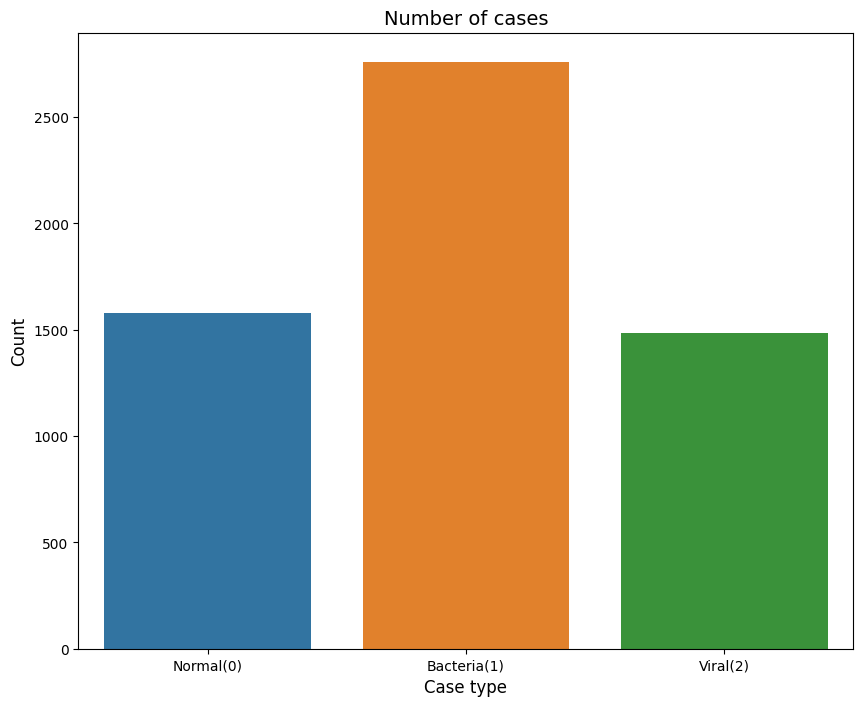

In [10]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x = cases_count.index, y = cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacteria(1)', 'Viral(2)'])
plt.show()

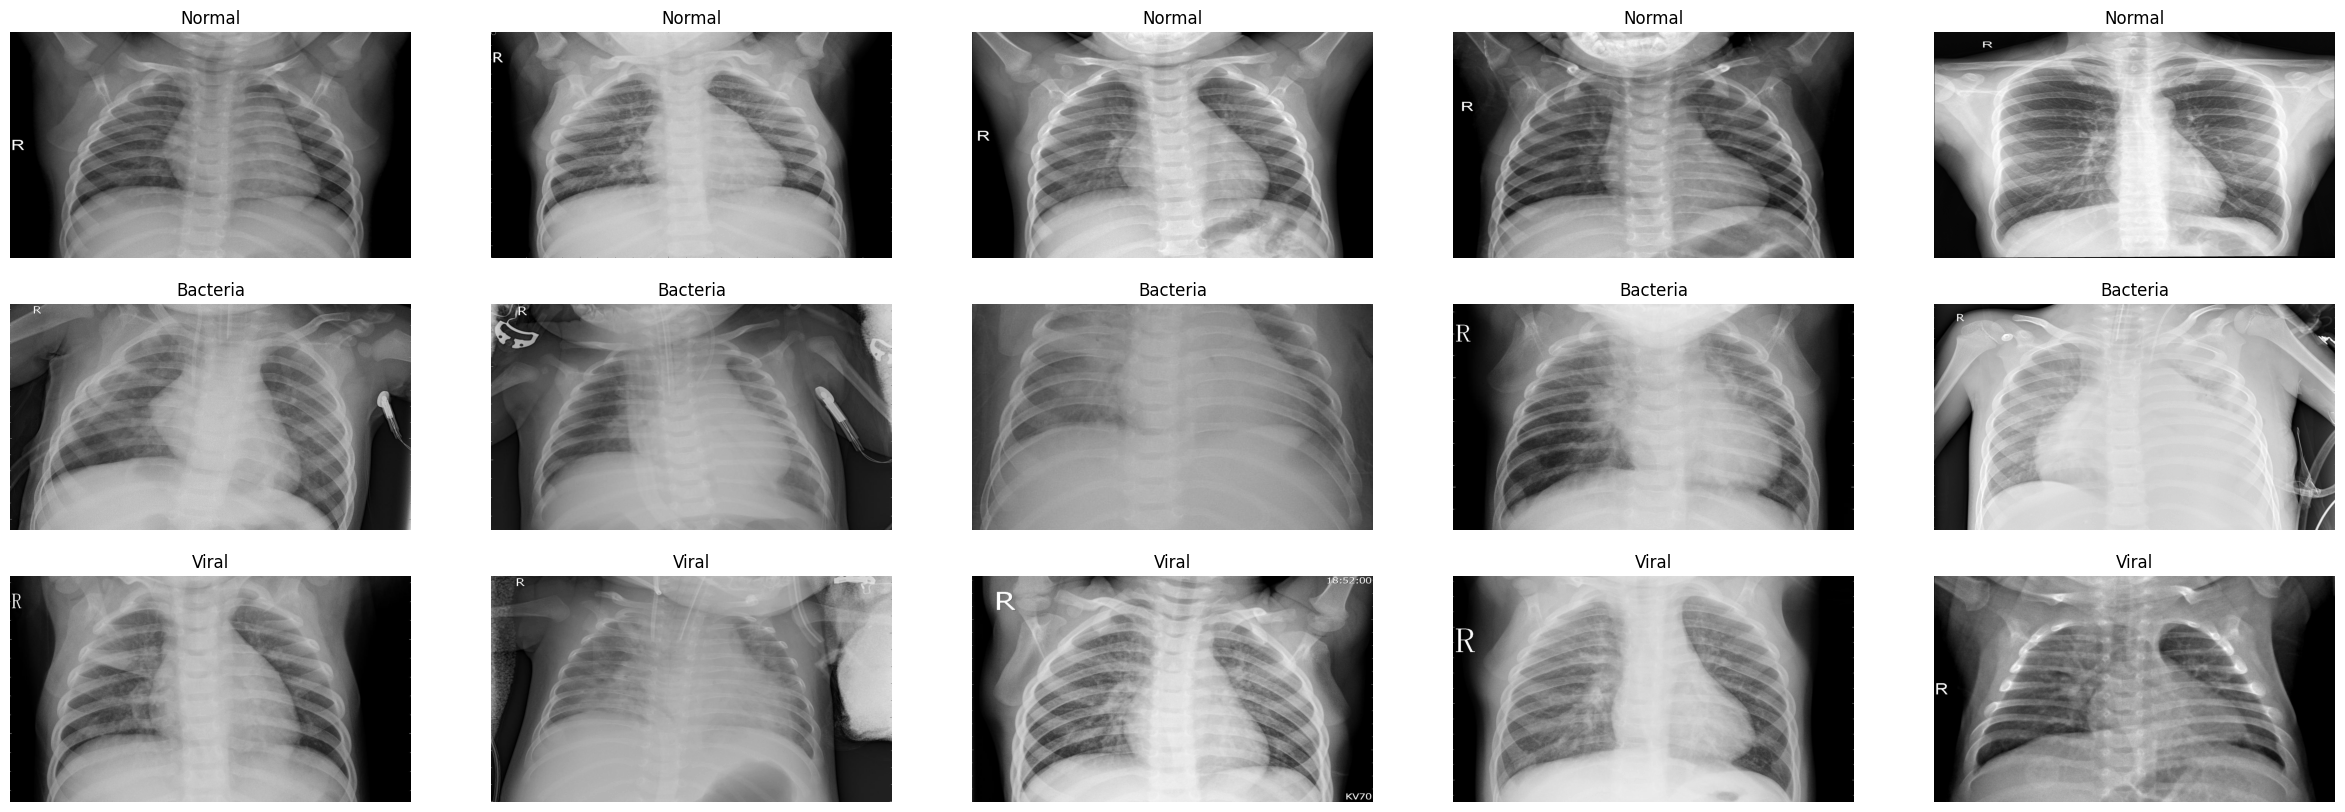

In [11]:
# Get few samples for both the classes
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
bacteria_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
viral_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above three list
samples = normal_samples + bacteria_samples + viral_samples
del bacteria_samples, normal_samples, viral_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,10))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    
    if i<5:
        ax[i//5, i%5].set_title("Normal")
    elif 5 <= i < 10:
        ax[i//5, i%5].set_title("Bacteria")
    else:
        ax[i//5, i%5].set_title("Viral")
    
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

# Uploading Val

In [12]:
# increase Val
valid_data = increase(valid_data, add_labels=add_labels)

# Preparing valid data
if 'seq' not in globals():
    valid_data = map(Conv, valid_data['image'].values, valid_data['label'].values)
else:
    valid_data_0 = map(Conv, valid_data[valid_data['add'] == 0]['image'].values, 
                     valid_data[valid_data['add'] == 0]['label'].values)
    
    valid_data_1 = map(Conv, valid_data[valid_data['add'] == 1]['image'].values, 
                     valid_data[valid_data['add'] == 1]['label'].values)
    
    valid_data = list(valid_data_0)
    for img, label in valid_data_1:
        valid_data.append((seq(image=img)['image'], label))
    
    #F = lambda img, label: (seq(imgage=img)['image'], label)
    #valid_data_1 = map(F, list(valid_data_1))
    
valid = []
valid_labels = []

for i, j in valid_data:
    valid.append(i.astype(np.float32)/255.)
    valid_labels.append(j)

# Convert the list into numpy arrays
valid_data = np.array(valid)
valid_labels = np.array(valid_labels)

def shuffle(x, y):
    p = np.random.permutation(len(y))
    return x[p], y[p]

valid_data, valid_labels = shuffle(valid_data, valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

del valid, valid_data_0, valid_data_1

Total number of validation examples:  (0,)
Total number of labels: (0,)


# MODEL cGAN

In [13]:
batch_size = 32
num_channels = 3
num_classes = 3
image_size = 224
latent_dim = 256

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

print(generator_in_channels, discriminator_in_channels)

259 6


In [20]:
# Create the discriminator.
input_img = layers.Input(shape=(224, 224, discriminator_in_channels), name='ImageInput')
    
x = layers.Conv2D(32, (3, 3), activation='selu', name='Conv2d_1')(input_img)
x = layers.MaxPooling2D((2, 2), name='max_pool_1')(x)

x = layers.Conv2D(32, (3, 3), activation='selu', name='Conv2d_2')(x)
x = layers.MaxPooling2D((2, 2), name='max_pool_2')(x)
    
x = layers.Conv2D(64, (3, 3), activation='selu', name='Conv2d_3')(x)
x = layers.MaxPooling2D((2, 2), name='max_pool_3')(x)

x = layers.Flatten(name='flatten')(x)

x = layers.Dense(64, activation='selu', name='fc_1')(x)
x = layers.Dropout(0.7, name='dropout_1')(x)

x = layers.Dense(32, activation='selu', name='fc_2')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)

x = layers.Dense(1, name='fc_3')(x)

Discriminator = keras.models.Model(inputs=input_img, outputs=x, name='Discriminator')
    
    
    
# Create the generator.
input_img = layers.Input(shape=(generator_in_channels), name='NoiseInput')

x = layers.Dense(14 * 14 * generator_in_channels, activation='selu', name='fc_1')(input_img)    
x = layers.Reshape((14, 14, generator_in_channels))(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation='selu')(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation='selu')(x)

x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", activation='selu')(x)

x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", activation='selu')(x)

x = layers.Conv2D(3, (7, 7), padding="same", activation="softmax")(x)

Generator = keras.models.Model(inputs=input_img, outputs=x, name='Generator')



# Model
Discriminator.summary()
Generator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 6)]     0         
                                                                 
 Conv2d_1 (Conv2D)           (None, 222, 222, 32)      1760      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 111, 111, 32)      0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 54, 54, 32)        0         
                                                                 
 Conv2d_3 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pool_3 (MaxPooling2D)   (None, 26, 26, 64)      

## Class GAN

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    #@tf.function
    def train_step(self, data):
        # Unpack the data.
        real_images, real_one_hot_labels = data

        # Create an array for discreminator
        real_image_one_hot_labels = real_one_hot_labels[:, :, None, None]
        real_image_one_hot_labels = tf.repeat(real_image_one_hot_labels, repeats=[image_size * image_size])
        real_image_one_hot_labels = tf.reshape(real_image_one_hot_labels, (-1, image_size, image_size, num_classes))

        # Sample random points in the latent space and concatenate the labels.
        random_latent_vectors = tf.random.normal(shape=(real_one_hot_labels.shape[0], latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, real_one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Code images for discreminator
        real_images_add = tf.concat([real_images, real_image_one_hot_labels], axis=3)
        generated_images_add = tf.concat([generated_images, real_image_one_hot_labels], axis=3)

        # Combine them with real images. Note that we are concatenating the labels
        combined_images = tf.concat([real_images_add, generated_images_add], axis=0)
        combined_labels = tf.concat([real_one_hot_labels, real_one_hot_labels], axis=0)

        # Assemble labels discriminating real from fake images.
        combined_index = tf.concat([tf.ones((real_one_hot_labels.shape[0], 1)),
                                    tf.zeros((real_one_hot_labels.shape[0], 1))], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(combined_index, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(real_one_hot_labels.shape[0], latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, real_one_hot_labels], axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((real_one_hot_labels.shape[0], 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_images_labels = tf.concat([fake_images, real_image_one_hot_labels], axis=3)
            predictions = self.discriminator(fake_images_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

## Fit

In [ ]:
# Get a train data generator
dataset = data_gen(data=train_data, batch_size=batch_size, Aug=seq, add_labels=add_labels)

# Define the number of training steps
nb_train_steps = 0
for i in range(3):
    nb_train_steps += (add_labels[i] + 1) * cases_count[i]

nb_epochs = 5
nb_train_steps //= batch_size

print("Number of training and validation steps: {}".format(nb_train_steps))

In [ ]:
cond_gan = ConditionalGAN(discriminator=Discriminator, generator=Generator, latent_dim=latent_dim)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

data = tf.data.Dataset.from_generator(
            lambda: data_gen(data=train_data, batch_size=batch_size, Aug=seq, add_labels=add_labels),
            output_types= (tf.float32, tf.float32),
            output_shapes= ((32,224, 224, 3),(32,3))
            )

In [ ]:
history_cGAN = cond_gan.fit(data, epochs=nb_epochs, steps_per_epoch=nb_train_steps)

## Save GAN

In [ ]:
GAN = cond_gan.generator
GAN.save('GAN_trained')

## Load GAN

In [ ]:
GAN_1 = keras.models.load_model('GAN_trained')

# MODEL CNN

In [ ]:
# Create the CNN
input_img = layers.Input(shape=(224,224,3), name='ImageInput')
    
x = layers.Conv2D(32, (3,3), activation='selu', name='Conv2d_1')(input_img)
#x = layers.BatchNormalization(name='bn_1')(x)
x = layers.MaxPooling2D((2,2), name='max_pool_1')(x)

x = layers.Conv2D(32, (3,3), activation='selu', name='Conv2d_2')(x)
#x = layers.BatchNormalization(name='bn_2')(x)
x = layers.MaxPooling2D((2,2), name='max_pool_2')(x)
    
x = layers.Conv2D(64, (3,3), activation='selu', name='Conv2d_3')(x)
#x = layers.BatchNormalization(name='bn_3')(x)
x = layers.MaxPooling2D((2,2), name='max_pool_3')(x)


x = layers.Flatten(name='flatten')(x)

x = layers.Dense(64, activation='selu', name='fc_1')(x)
x = layers.Dropout(0.7, name='dropout_1')(x)

x = layers.Dense(32, activation='selu', name='fc_2')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)

x = layers.Dense(3, activation='softmax', name='fc_3')(x)

Discriminator = keras.models.Model(inputs=input_img, outputs=x, name='CNN')
    
#kernel_regularizer='l2'
    
# Model
Discriminator.summary()

## Fit

In [ ]:
# CallBack
my_callbacks = [keras.callbacks.EarlyStopping(patience=5),
               keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=True),
               tf.keras.callbacks.CSVLogger('log.scv', separator=",", append=False)]

# Optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)
# opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Compile
Discriminator.compile(loss='CategoricalCrossentropy', metrics=['accuracy'], optimizer=opt)

In [ ]:
batch_size = 32
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size, Aug=seq, add_labels=add_labels)

# Define the number of training steps
nb_train_steps = 0
for i in range(3):
    nb_train_steps += (add_labels[i] + 1) * cases_count[i]
    
nb_train_steps //= batch_size    
print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

In [ ]:
# # Fit the model

history = Discriminator.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                   validation_data=(valid_data, valid_labels), callbacks=my_callbacks)
# class_weight={0:2.0, 1:1, 2:2.0}

## Plots of loss and accuracy

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения")
plt.plot(epochs, val_loss, "b", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()

plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Точность на этапе обучения")
plt.plot(epochs, val_acc, "b", label="Точность на этапе проверки")
plt.title("Точность на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend()
plt.show()

# Load the best model

In [ ]:
Discriminator.load_weights('best_model.hdf5')

# Uploading Train

In [ ]:
# increase Test
test_data = increase(test_data, add_labels=add_labels)

# Preparing test data
if 'seq' not in globals():
    test_data = map(Conv, test_data['image'].values, test_data['label'].values)
else:
    test_data_0 = map(Conv, test_data[test_data['add'] == 0]['image'].values, 
                     test_data[test_data['add'] == 0]['label'].values)
    
    test_data_1 = map(Conv, test_data[test_data['add'] == 1]['image'].values, 
                     test_data[test_data['add'] == 1]['label'].values)
    
    test_data = list(test_data_0)
    for img, label in test_data_1:
        test_data.append((seq(image=img)['image'], label))
        
test = []
test_labels = []

for i, j in test_data:
    test.append(i.astype(np.float32)/255.)
    test_labels.append(j)

# Convert the list into numpy arrays
test_data = np.array(test)
test_labels = np.array(test_labels)

def shuffle(x, y):
    p = np.random.permutation(len(y))
    return x[p], y[p]

test_data, test_labels = shuffle(test_data, test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

del test, test_data_0, test_data_1

# Test model

In [ ]:
# Evaluation on test dataset
test_loss, test_score = Discriminator.evaluate(test_data, test_labels, batch_size=32)

print()

x_0 = 0
x_1 = 0
x_2 = 0
for i in range(test_labels.shape[0]):
    if test_labels[i][0]:
        x_0 += 1
    elif test_labels[i][1]:
        x_1 += 1
    else:
        x_2 += 1
        
print(x_0, x_1, x_2, '- EXAMPLES')

print()

print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

In [ ]:
# Get predictions
preds = Discriminator.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

# ConfusionMatrix and Metrics

In [ ]:
cm  = confusion_matrix(y_true=orig_test_labels, y_pred=preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacteria', 'Viral'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacteria', 'Viral'], fontsize=16)
plt.show()

In [ ]:
# Calculate error rate 
accuracy = (cm[0][0] + cm[1][1] + cm[2][2]) / (sum(cm.ravel())) 

Recall_0 = cm[0][0] / (cm[0][0] + cm[1][0] + cm[2][0])
Recall_1 = cm[1][1] / (cm[0][1] + cm[1][1] + cm[2][1])
Recall_2 = cm[2][2] / (cm[0][2] + cm[1][2] + cm[2][2])

Precision_0 = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
Precision_1 = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
Precision_2 = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])

F_0 = 2 / (1 / Precision_0 + 1 / Recall_0)
F_1 = 2 / (1 / Precision_1 + 1 / Recall_1)
F_2 = 2 / (1 / Precision_2 + 1 / Recall_2)

print("Accuracy of the Discriminator is {:.2f}".format(accuracy))

print()

print("Recall of the first class is {:.2f}".format(Recall_0))
print("Recall of the second class is {:.2f}".format(Recall_1))
print("Recall of the third class is {:.2f}".format(Recall_2))

print()

print("Precision of the first class is {:.2f}".format(Precision_0))
print("Precision of the second class is {:.2f}".format(Precision_1))
print("Precision of the third class is {:.2f}".format(Precision_2))

print()

print("F of the first class is {:.2f}".format(F_0))
print("F of the second class is {:.2f}".format(F_1))
print("F of the third class is {:.2f}".format(F_2))